In [1]:
from PIL import Image
from pathlib import Path
import numpy as np

In [2]:
pip install numpy

You should consider upgrading via the 'c:\Users\barki\AppData\Local\Programs\Python\Python37\python.exe -m pip install --upgrade pip' command.


# Data Pre-processing
## Create RGB patches

In [2]:
def create_rgb_pil (red_filename: Path):
    
    # set the filenames for each patch
    red_fn = str(red_filename)
    blue_fn = red_fn.replace('red','blue')
    green_fn = red_fn.replace('red', 'green')
    rgb_fn = red_fn.replace('red', 'rgb').replace('.TIF', '.png')
    
    # open red, green and blue patches as numpy arrays
    arr_red = np.array(Image.open(red_fn))
    arr_green = np.array(Image.open(green_fn))
    arr_blue = np.array(Image.open(blue_fn))
    
    # stack them into a single 384x384x3 RGB array
    arr_rgb = np.stack([arr_red, arr_green, arr_blue], axis=2)
    
    # as the original TIF values are UINT16 with absolute values up to 65535, we normalize them 
    # between 0 and 1
    arr_rgb = arr_rgb / np.iinfo(arr_rgb.dtype).max
    
    # create RGB PIL image 
    rgb = Image.fromarray((256*arr_rgb).astype(np.uint8), 'RGB')
    
    # save the image into output folder
    rgb.save(rgb_fn)
    
    return rgb
    
    

In [3]:
base_path = Path('L:/BarkinDownloads/38clouds/38-Cloud_training/')

# create the rgb output dir
if not (base_path/'train_rgb').exists():
    (base_path/'train_rgb').mkdir()

# loop trough the red patches and create the corresponding rgb ones
for red_patch in (base_path/'train_red').iterdir():
    try:
        create_rgb_pil(red_patch)
    except Exception:
        pass

## Convert Ground Truth to PNG

In [4]:
def convert_tif_png(tif_filename: Path, out_folder:Path):
    arr_tif = np.array(Image.open(tif_filename))

    # change values from 255 to 1
    im = Image.fromarray(np.where(arr_tif==255, 1, 0))

    im.save(out_folder/tif_filename.with_suffix('.png').name)
    
    return im


In [5]:
# sets the base path
base_path = Path('L:/BarkinDownloads/38clouds/38-Cloud_training')

if not (base_path/'labels').exists():
    (base_path/'labels').mkdir()

for gt_patch in (base_path/'train_gt').iterdir():
    convert_tif_png(gt_patch, base_path/'labels')

After finishing the pre-processing step, we should organize the data into data/images and data/labels folders. Let's create a data folder, move train_rgb and labels into it and then rename train_rgb into images. 

# Creating the Data Loader

In [12]:
from fastai.vision.all import *

path_data = Path('L:/BarkinDownloads/38clouds/38-Cloud_training')

path_lbl = path_data/'labels' # path for labels
path_img = path_data/'train_rgb' # path for the images 

img_names = get_image_files(path_img) # the collection of files for the images
lbl_names = get_image_files(path_lbl) # for labels 

print(len(img_names), len(lbl_names))

8400 8400


<AxesSubplot:>

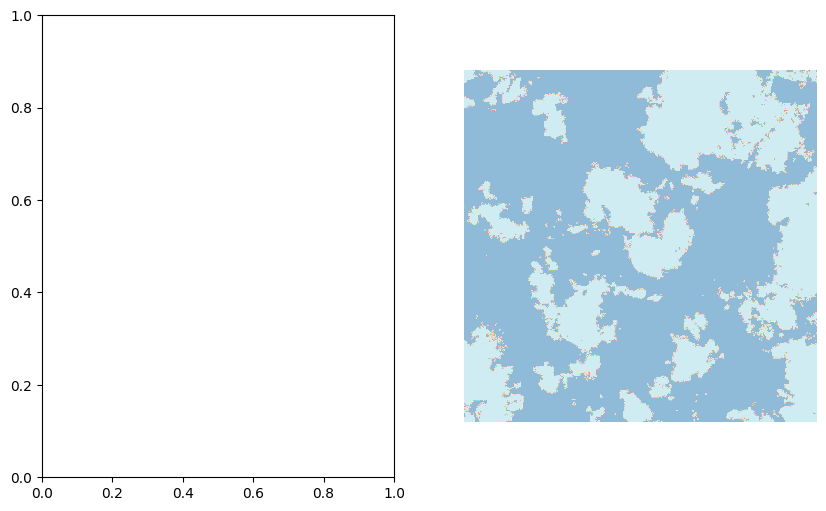

In [72]:
import matplotlib.pyplot as plt

def get_lbl_fn(img_fn: Path):  
  
  img_name = img_fn.name 
  lbl_name = img_name.replace('rgb', 'gt')

  return img_fn.parent.parent/('labels/' + lbl_name)

fname = Path(path_img/'rgb_patch_200_10_by_11_LC08_L1TP_034034_20160520_20170223_01_T1.png')

img = load_image(fname)
mask = OpenMask(get_lbl_fn(fname))

fig, ax = plt.subplots(1,2, figsize=(10,6))

img.show(ax[0])
mask.show(ax[1])

In [68]:
import glob
dir_path = r'L:/BarkinDownloads/38clouds/38-Cloud_training/train_rgb/*.*'
res = glob.glob(dir_path)


data = ImageDataLoaders.from_path_func(path_img, res, get_lbl_fn, valid_pct=0.2,seed=None, item_tfms=None)
data


In [69]:
data.show_batch(2)

TypeError: isinstance() arg 2 must be a type or tuple of types

NameError: name 'data' is not defined

# The Model

In [73]:
def acc_metric(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

wd = 1e-2

lr=1e-3 #loss ratio 

learn = unet_learner(data, models.resnet34, metrics=acc_metric, wd=wd) #uses 34 layer resnet CNN 

learn.fit_one_cycle(3, lr) 

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\barki/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:10<00:00, 8.72MB/s]


epoch,train_loss,valid_loss,acc_metric,time


RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 905969664 bytes.

epoch,train_loss,valid_loss,acc_metric,time
0,0.247730,0.132063,0.950202,15:02
1,0.142790,0.118204,0.953499,14:41
2,0.120431,0.101199,0.960386,14:42


In [ ]:
learn.save('38_cloud_medium_Resnet34')

In [ ]:
img = learn.data.valid_ds.x[22]
mask = learn.data.valid_ds.y[22]
pred = learn.predict(img)[0]

fig, ax = plt.subplots(1,3, figsize=(12,6))

img.show(ax[0])
mask.show(ax[1])
pred.show(ax[2])

In [ ]:
prediction = learn.predict(img)
prediction[0]

epoch,train_loss,valid_loss,acc_metric,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


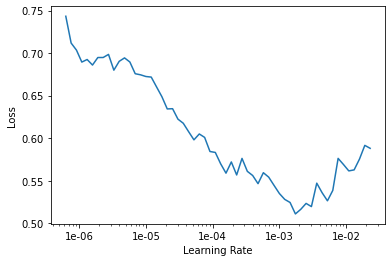

In [ ]:
lr_find(learn)
learn.recorder.plot()

# The Results

In [ ]:
learn.save('38_cloud_medium_Resnet34')

img = learn.data.valid_ds.x[22]
mask = learn.data.valid_ds.y[22]
pred = learn.predict(img)[0]

fig, ax = plt.subplots(1,3, figsize=(12,6))

img.show(ax[0])
mask.show(ax[1])
pred.show(ax[2])